In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
def multi_indexing(df: pd.DataFrame, stats: dict[str, str]) -> pd.DataFrame:
    # set the multi index based on event & player name
    multiIndexDf = df.set_index(['EVENT', 'PLAYER NAME'], inplace=False)
    
    rtnDf = multiIndexDf[[*stats.keys()]]
    
    return rtnDf.rename(columns = stats)

In [3]:
csvs = ["driving_distance", "driving_accuracy", "greens_in_regulation", "proximity_to_the_hole","scrambling","sand_saves","putts_per_round"]

statsMap = {
  "driving_distance" : {
    'AVG.' : 'Driving Distance',
    'TOTAL DRIVES' : 'Total Drives'
  },
  "driving_accuracy": {
    '%' : 'Fairways Hit (%)',
    'FAIRWAYS HIT':  'Fairsways Hit',
    'POSSIBLE FAIRWAYS' : 'Possible Fairways'
  },
  "greens_in_regulation": {
    '%' : 'Greens Hit (%)'
  },
     "proximity_to_the_hole": {
    'AVG' : 'Hole Proximity',
    'GIR RANK': 'GIR Rank'
  },
    "putts_per_round": {
    'AVG' : 'Putts'
  },
  "sand_saves": {
    '%' : 'Sand Saves (%)',
    '# SAVES': 'Sand Saves',
    '# BUNKERS' : 'Bunkers'
  },
  "scrambling" : {
    '%' : 'Scrambling (%)',
    'PAR OR BETTER' : 'Scarmbling',
    'MISSED GIR' : 'Missed GIR'
  },
}

IMPORTANT NOTES

- each stat is a 4 day average
- only players who make it to the final round (4 rounds) are considered

In [4]:
# set up inital scoring df
scoringDf = pd.read_csv('../data/raw_data/scoring_average.csv')
aggratedData = multi_indexing(scoringDf, {'AVG': 'Score'})

for file in csvs:
    currDf = pd.read_csv(f'../data/raw_data/{file}.csv')
    currDict = statsMap[file]
    
    cleanedDf = multi_indexing(currDf, currDict)
    aggratedData = pd.merge(aggratedData, cleanedDf, on=['EVENT', 'PLAYER NAME'])

aggratedData.head()

Score  Driving Distance  Total Drives  \
EVENT     PLAYER NAME                                                 
U.S. Open Matt Fitzpatrick   65.903             310.5             8   
          Scottie Scheffler  66.153             313.3             8   
          Will Zalatoris     66.153             306.3             8   
          Hideki Matsuyama   66.653             295.9             8   
          Rory McIlroy       66.903             300.9             8   

                             Fairways Hit (%)  Fairsways Hit  \
EVENT     PLAYER NAME                                          
U.S. Open Matt Fitzpatrick              69.64             39   
          Scottie Scheffler             67.86             38   
          Will Zalatoris                55.36             31   
          Hideki Matsuyama              51.79             29   
          Rory McIlroy                  55.36             31   

                             Possible Fairways  Greens Hit (%) Hole Proximity  \
EVENT     PLAYER NAME                                                           
U.S. Open Matt Fitzpatrick                  56           72.22        35' 10"   
          Scottie Scheffler                 56           65.28         33' 9"   
          Will Zalatoris                    56           65.28         28' 3"   
          Hideki Matsuyama                  56           69.44         33' 7"   
          Rory McIlroy                      56           66.67         35' 2"   

                            GIR Rank  Scrambling (%)  Scarmbling  Missed GIR  \
EVENT     PLAYER NAME                                                          
U.S. Open Matt Fitzpatrick   6 Under           60.00          12          20   
          Scottie Scheffler  5 Under           60.00          15          25   
          Will Zalatoris     5 Under           52.00          13          25   
          Hideki Matsuyama   3 Under           72.73          16          22   
          Rory McIlroy       2 Under           54.17          13          24   

                             Sand Saves (%)  Sand Saves  Bunkers  Putts  
EVENT     PLAYER NAME                                                    
U.S. Open Matt Fitzpatrick            42.86           3        7  30.50  
          Scottie Scheffler           50.00           3        6  27.75  
          Will Zalatoris              60.00           3        5  28.25  
          Hideki Matsuyama            42.86           3        7  29.25  
          Rory McIlroy               100.00           5        5  29.00

Okay now let's visualize our data to better understand the underlying nature to properly choose our analysis tool.

In [5]:
def print_hist(df: pd.DataFrame):
    for i in df.columns:
        plt.hist(df[i], 20)
        plt.title(i)
        plt.show()

C:\Users\kmong\AppData\Local\Temp\ipykernel_6288\1987397415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Hole Proximity'] = subset['Hole Proximity'].apply(lambda x: format_feet(x))


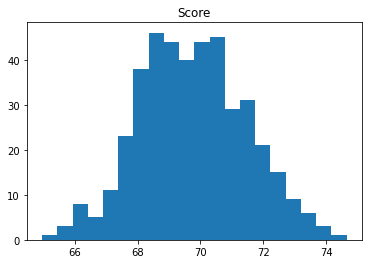

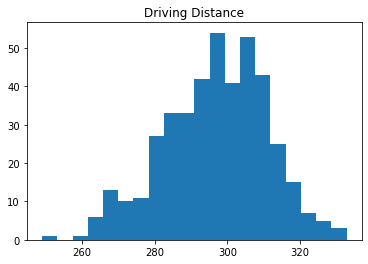

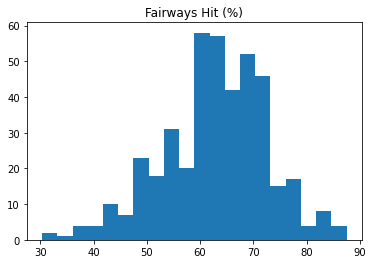

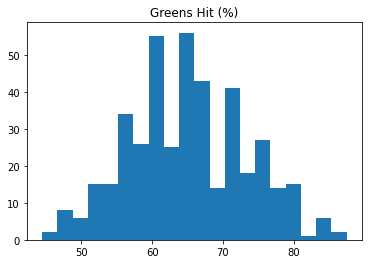

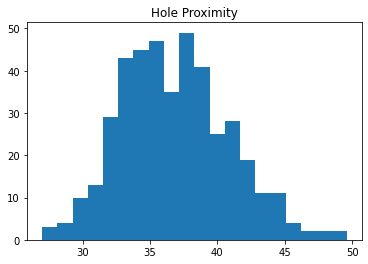

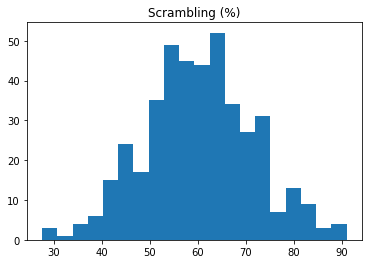

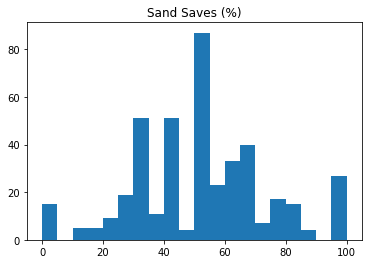

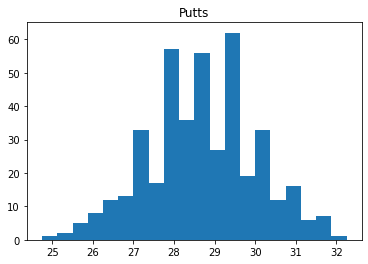

In [6]:
#Drop the histograms that are not normally distributed and use only % to leverge CLT in my display
subset = aggratedData[['Score','Driving Distance', 'Fairways Hit (%)', 'Greens Hit (%)', 'Hole Proximity', 'Scrambling (%)','Sand Saves (%)', 'Putts' ]]

#format the hole proximity to a feet number (XX/' X")
def format_feet(x: str) -> str:
    # format 30' 5"
    splitList = x.split("' ")
    ft = float(splitList[0])
    inch = float(splitList[1].replace('"', ''))
    return ft + inch/12

subset['Hole Proximity'] = subset['Hole Proximity'].apply(lambda x: format_feet(x))
print_hist(subset)

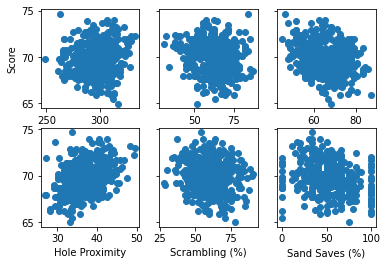

In [11]:
# understanding each feature's relationship with the dependent variable (score)
yAxis = aggratedData['Score']
features = [['Driving Distance', 'Fairways Hit (%)', 'Greens Hit (%)'], ['Hole Proximity', 'Scrambling (%)','Sand Saves (%)', 'Putts']]

fig, ax = plt.subplots(2,3, sharey=True)
num = 0

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i, j].scatter(subset[features[i][j]], yAxis)
        ax[i, j].set_xlabel(features[i][j])
    
ax[0,0].set_ylabel('Score')
plt.show()  

                  Driving Distance  Fairways Hit (%)  Greens Hit (%)  \
Driving Distance          1.000000         -0.409994        0.256419   
Fairways Hit (%)         -0.409994          1.000000        0.215172   
Greens Hit (%)            0.256419          0.215172        1.000000   
Hole Proximity            0.179869         -0.299171       -0.194700   
Scrambling (%)            0.129106          0.097118        0.272301   
Sand Saves (%)           -0.074188          0.070242        0.086136   
Putts                    -0.016764          0.039094        0.323487   

                  Hole Proximity  Scrambling (%)  Sand Saves (%)     Putts  
Driving Distance        0.179869        0.129106       -0.074188 -0.016764  
Fairways Hit (%)       -0.299171        0.097118        0.070242  0.039094  
Greens Hit (%)         -0.194700        0.272301        0.086136  0.323487  
Hole Proximity          1.000000        0.082099       -0.028865 -0.137540  
Scrambling (%)          0.082099      

<AxesSubplot:>

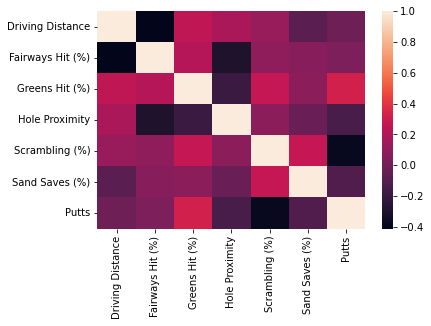

In [32]:
#look at the correlation
#correlation for independant variables
independentSubset = subset.loc[:, subset.columns != 'Score']

print(independentSubset.corr())
sns.heatmap(independentSubset.corr())

In [33]:
#need to find the guildlines for correlation in linear regression features
#since driving distance, hole proximity and putts are not percentages, lets scale the date to increase gradient decent performance
#apply z-score averaging to scale data
def scaling_helper(df: pd.DataFrame):
    for i in df.columns:
        stdDev = df[i].std()
        mean = df[i].mean()
        
        df[i] = df[i].apply(lambda x: (x - mean)/stdDev)

scaling_helper(independentSubset)

C:\Users\kmong\AppData\Local\Temp\ipykernel_7272\977614529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].apply(lambda x: (x - mean)/stdDev)


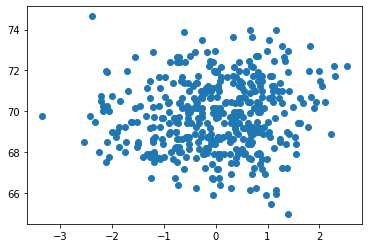

In [29]:
subset['Driving Distance'].describe()
plt.scatter(subset['Driving Distance'], aggratedData['Score'])

In [36]:
# I will also need to divide the data set into a 80/20 training/testing in the future
train, test = train_test_split(subset, test_size=0.2)

# subsetDf = train.loc[:, aggratedData.columns != 'Score']
x_train = train.loc[:, train.columns != 'Score']
y_train = train['Score']

print(f'X: {x_train.shape}, Y: {y_train.shape}')

X: (338, 7), Y: (338,)


#### Define Linear Function and Cost Function

Linear Function is defined as a summation of each feature multipied by a calculated weight and a base value:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 

The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 




In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [ ]:
def compute_cost(data, y, w, b) -> float:
    '''
    data (ndarray (m,n)): Data, m examples with n features
    y (ndarray (m,)) : target values, actual y values
    w (ndarray (n,)) : model parameters, weights  
    b (scalar)       : model parameter, base value
    
    '''
    # set number of row and initiate cost at 0
    m = data[0]
    cost = 0.0
    
    # calculate summation
    for i in range(m):
        
        # calculate linear function
        linearFn = np.dot(w, data[i]) + b 
        # find the difference between predicted and given value
        cost += (linearFn - y[i]) ** 2

    # account for number of rows (multiple by 2 to account for differiation)
    return cost / (2 * m)

#### 5 Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$
\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}
$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


In [ ]:
def compute_gradient(data, y, w, b):
    '''
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
      
    '''
    m, n = data.shape # will return (number of rows, number of features)
    
    #define partial deratives in respect to a weight or base
    pj_pw = np.zeros((n,))
    pj_pb = 0.0
    
    #summation
    for i in range(m):
        # compute the error (linFun - y)
        err = (np.dot(w, data[i]) + b) - y[i]
        
        # compute the new weight partial derative 
        for j in range(n):
            pj_pw[j] =+ err * data[i][j]
        
        pj_pb =+ err
    
    return (pj_pw / m), (pj_pb / m)
    

In [12]:
# assign some inital b and w values

b_init = 1
w_init = np.array([1,1,1,1,1,1,1])

In [ ]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

Data Scaling with contour plots to show the change (from skinny to more circular)
- take the original verision and divide by the maxmium (1)
- mean normalization, find the mean then subtract the mean from any value and divide it by the range of possibilities
- z-score, use the std.dev and mean of each feature, (value - mean) / std.dev

*aim for all feature to range between -1 to 1, or 0<x<3 

Look into gradiant decent to mimize cost function (the amount of errors that exist in the model, for linear regression this can be the mean square error) this is limited to only find the local minima, and work on completly differentiable functions (non-peicewise), in linear regression that the function is a convex function

Learning rate implications is too small, it will take too long, too large it will overshoot the minima (fail to converge/diverge)

batch gradient descent -> each step of gradient descent looks at all training examples instead of a subset

https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/optimizing-multivariable-functions/a/what-is-gradient-descent#:~:text=Gradient%20descent%20is%20an%20algorithm,like%20we've%20seen%20before.

Look into m

$$ a \ne $$

- LatEX notation for math


talk about vectorization with numpy arrays (dot product) np.dot()

//PLOTS

- after each iteration of gradiate descent I should plot the values (value vs # of iterations) LEARNING CURVE
  - try with a 3x multiplier on the learning rate (alpha)
  - try with maybe 200 iterations
- automatic convergence test (use a check with an epsilion, very small value 10^-3) after each iteration check if the change is less than the epsilion